In [1]:
import pandas as pd
import numpy as np
import sklearn.linear_model

from sklearn import linear_model, model_selection
from sklearn import metrics

data = pd.read_csv('communities.data', header = None)

num_row, num_col = data.shape

### Question 1

In [2]:
selected_column = []

for j in range(num_col-1):
    valcount = data.iloc[:,j].value_counts()
    if '?' not in valcount:
        selected_column.append(j)
    elif valcount['?'] < 0.01 * num_row:
        valmean = pd.to_numeric(data.iloc[:,j], errors='coerce').mean()
        for i in range(num_row):
            if data.iloc[i,j] == '?':
                data.iloc[i,j] = valmean
        data.iloc[:,j] = pd.to_numeric(data.iloc[:,j])
        selected_column.append(j)

In [3]:
data[selected_column]

,0,3,4,5,6,7,8,9,10,11,...,95,96,97,98,99,100,118,119,120,125
0,8,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,...,0.00,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32
1,53,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,...,0.00,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00
2,24,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,...,0.00,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00
3,34,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,...,0.00,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00
4,42,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,...,0.00,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,0.16,0.43,...,0.00,0.22,0.28,0.34,0.48,0.39,0.01,0.28,0.05,0.00
1990,6,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,0.32,0.69,...,0.00,0.53,0.25,0.17,0.10,0.00,0.02,0.37,0.20,0.00
1991,9,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,0.25,0.35,...,0.02,0.25,0.68,0.61,0.79,0.76,0.08,0.32,0.18,0.91
1992,25,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,0.10,0.58,...,0.01,0.45,0.64,0.54,0.59,0.52,0.03,0.38,0.33,0.22


Before cleaning up the data based on number of missing values as required in the question,
we need to remove some attributes that are purely used to define state, county, community and community name.

`communities.name` file shows that column 0 - 4 are state, county, community, communityname and fold values. Therefore,
we will not include these columns into analysis.

The last column (column 127) represents "ViolentCrimesPerPop" and it is the target / goal attribute that needs to be predicted.

In [4]:
selected_column = [ind for ind in selected_column if ind not in [0,3,4]]

<AxesSubplot:>

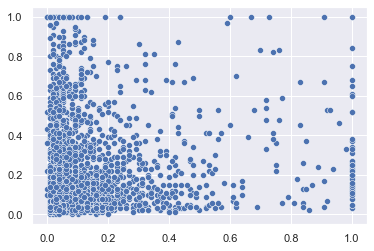

In [5]:
#plot several scatter plots by changing x_val column to understand how the data looks like.
import seaborn as sb
sb.set()
#change value of x_val column as needed
x_val = data.iloc[:,9].values
y_val = data.iloc[:,-1].values
sb.scatterplot(x=x_val, y=y_val)

Splitting the data into train and test data.

In [6]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data.iloc[:,selected_column].values, \
                                                                    data.iloc[:,-1].values, \
                                                                    test_size = 0.1, \
                                                                    random_state = 2019)

#### 1) Linear Regression

In [7]:
linear_reg = linear_model.LinearRegression()
linear_reg.fit(x_train, y_train)
y_linear_reg_pred = linear_reg.predict(x_test)

print('R^2 score:\t\t\t\t',linear_reg.score(x_test, y_test))
print('Explained Variance: \t\t\t', metrics.explained_variance_score(y_test, y_linear_reg_pred))
print('Mean Absolute Error: \t\t\t', metrics.mean_absolute_error(y_test, y_linear_reg_pred))
print('Mean Squared Error:\t\t\t', metrics.mean_squared_error(y_test, y_linear_reg_pred))

# Manual computation of R^2 score
sst = np.sum((y_test - np.mean(y_test)) ** 2)
sse = np.sum((linear_reg.predict(x_test) - y_test) ** 2)
print('R^2 score computed from ssr / sst:\t', 1 - sse / sst)

R^2 score:				 0.614531843419579
Explained Variance: 			 0.6172084335596153
Mean Absolute Error: 			 0.09298904853282242
Mean Squared Error:			 0.015880122973610074
R^2 score computed from ssr / sst:	 0.614531843419579


**MSE of the linear regression on test data: 0.015880122973610074**

#### 2) Lasso Regression

In [8]:
# creating a table to print result
alpha = [0.001, 0.01, 0.1, 1]

for i in range(4):
    #build lasso regressor here
    lasso = linear_model.Lasso(alpha=alpha[i])
    lasso.fit(x_train, y_train)
    y_pred_lasso = lasso.predict(x_test)
    mse = metrics.mean_squared_error(y_test, y_pred_lasso)
    cplxy = np.linalg.norm(lasso.coef_[1:]) #removing w0 coefficient
    print('-' * 32)
    print('lasso with alpha', alpha[i])
    print('-' * 32)
    print('MSE on test set:', mse)
    print('model complexity:', cplxy)
    print('regularized cost:', mse + alpha[i] * cplxy)

--------------------------------
lasso with alpha 0.001
--------------------------------
MSE on test set: 0.015857788737502113
model complexity: 0.4454910988770553
regularized cost: 0.016303279836379168
--------------------------------
lasso with alpha 0.01
--------------------------------
MSE on test set: 0.01799020892011145
model complexity: 0.3771984622157508
regularized cost: 0.021762193542268958
--------------------------------
lasso with alpha 0.1
--------------------------------
MSE on test set: 0.042008436555519515
model complexity: 0.0
regularized cost: 0.042008436555519515
--------------------------------
lasso with alpha 1
--------------------------------
MSE on test set: 0.042008436555519515
model complexity: 0.0
regularized cost: 0.042008436555519515


In [9]:
# Understanding Lasso regression in further details
lasso_coef = []
for alpha in [0.001, 0.01, 0.1, 1]:
    lasso = linear_model.Lasso(alpha=alpha)
    lasso.fit(x_train, y_train)
    print('coef_ with','alpha =',alpha,'):', list(map(lambda x: round(x, 3), lasso.coef_)))
    lasso_coef.append(lasso.coef_)

coef_ with alpha = 0.001 ): [0.0, -0.0, 0.124, -0.059, 0.0, 0.0, -0.0, -0.008, -0.024, 0.0, 0.0, 0.035, 0.0, -0.003, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.001, 0.004, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.115, -0.0, 0.0, 0.0, 0.0, -0.0, -0.277, -0.0, -0.0, -0.0, -0.056, 0.0, 0.205, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.135, 0.0, -0.0, 0.127, -0.041, 0.0, 0.026, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.002, 0.0, -0.028, 0.0, 0.069, 0.015, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.009]
coef_ with alpha = 0.01 ): [0.0, -0.0, 0.0, -0.172, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.238, -0.0, -0.0, -0.0, -0.0, 0.0, 0.237, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 

Let's try to plot the Lasso regression coefficient changes by alpha value.

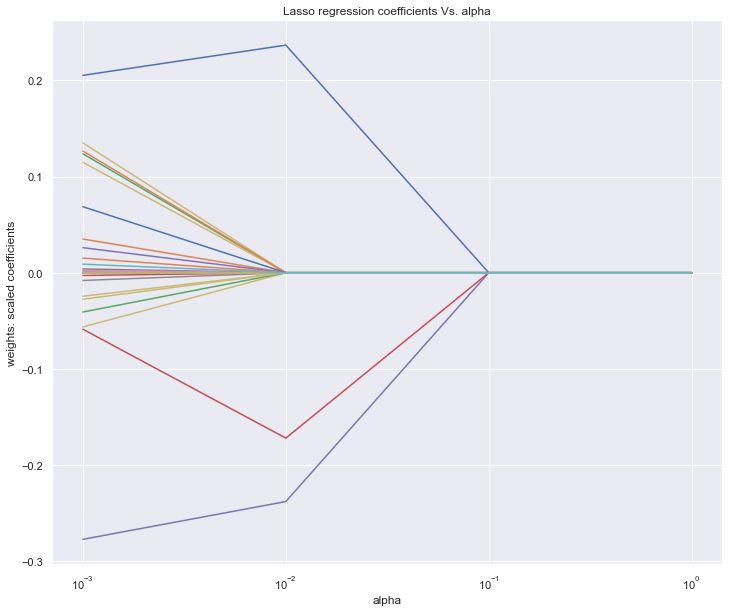

In [10]:
import matplotlib.pyplot as plt

alpha_lasso = np.array([0.001, 0.01, 0.1, 1])
df = data.iloc[:,selected_column]
# number of x (variables) is 100
plt.figure(figsize=(12,10))
ax = plt.gca()
ax.plot(alpha_lasso, lasso_coef)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights: scaled coefficients')
plt.title('Lasso regression coefficients Vs. alpha')
#plt.legend(df.columns, loc='right')
plt.show()

In [11]:
# trying out cross validation to see what could be the optimal lambdas for Lasso
lassocv = linear_model.LassoCV()
lassocv.fit(x_train, y_train)

# for each alpha, how many variables does not have 0 weightage.
print('count non 0 weightage x variables with alpha = 0.001 : ',len([x for x in lasso_coef[0] if x != 0.0]))
print('count non 0 weightage x variables with alpha = 0.01  : ',len([x for x in lasso_coef[1] if x != 0.0]))
print('count non 0 weightage x variables with alpha = 0.1   : ',len([x for x in lasso_coef[2] if x != 0.0]))
print('count non 0 weightage x variables with alpha = 1     : ',len([x for x in lasso_coef[3] if x != 0.0]))
print('-' * 32)
print('optimal alpha value using LassoCV() function: ', float(lassocv.alpha_))

count non 0 weightage x variables with alpha = 0.001 :  21
count non 0 weightage x variables with alpha = 0.01  :  3
count non 0 weightage x variables with alpha = 0.1   :  0
count non 0 weightage x variables with alpha = 1     :  0
--------------------------------
optimal alpha value using LassoCV() function:  8.093833721427848e-05


| Lasso | alpha = 0.001 | alpha = 0.01 | alpha = 0.1 | alpha = 1 |
|---|---|---|---|---|
| MSE on test data | 0.015857788737502113 | 0.01799020892011145 | 0.042008436555519515 | 0.042008436555519515 |
| model complexity | 0.4454910988770553 | 0.3771984622157508 | 0.0 | 0.0 |
| regularized cost | 0.016303279836379168 | 0.021762193542268958 | 0.042008436555519515 | 0.042008436555519515 |

**Question: which lasso regressor will you choose?**

I would choose lasso regressor with alpha = 0.001. Out of 100 different factors, Lasso regression managed to fit the model
with 21 factors. At the same time, the MSE is smallest and it is similar to MSE of linear regression we fit in 1)Linear
regression. With too high alpha values such as >0.1 ended up ignoring all factors, which is not desirable.

#### 3) Ridge Regression

In [12]:
alpha = [0.001, 0.01, 0.1, 1]

for i in range(4):
    #build ridge regressor here
    ridge = linear_model.Ridge(alpha=alpha[i])
    ridge.fit(x_train, y_train)
    y_pred_ridge = ridge.predict(x_test)
    mse = metrics.mean_squared_error(y_test, y_pred_ridge)
    cplxy = np.sqrt(sum(ridge.coef_[1:]**2))
    print('-' * 32)
    print('ridge with alpha', alpha[i])
    print('-' * 32)
    print('MSE on test set:', mse)
    print('model complexity:', cplxy)
    print('regularized cost:', mse + alpha[i] * cplxy)


--------------------------------
ridge with alpha 0.001
--------------------------------
MSE on test set: 0.015874346032957988
model complexity: 2.0222666233873876
regularized cost: 0.017896612656345377
--------------------------------
ridge with alpha 0.01
--------------------------------
MSE on test set: 0.01583346386799007
model complexity: 1.883011237939854
regularized cost: 0.03466357624738861
--------------------------------
ridge with alpha 0.1
--------------------------------
MSE on test set: 0.01568893130587988
model complexity: 1.4110489787812535
regularized cost: 0.15679382918400525
--------------------------------
ridge with alpha 1
--------------------------------
MSE on test set: 0.015364916870959254
model complexity: 0.8362117138484134
regularized cost: 0.8515766307193726


In [13]:
ridge_coefs = []
#Test out additional training to see how model changes as alpha values changes
for alpha in [0.001, 0.01, 0.1, 1, 5, 10, 100]:
    ridge = linear_model.Ridge(alpha=alpha)
    ridge.fit(x_train, y_train)
    print('\nTrain score:', round(ridge.score(x_train, y_train), 3))
    print('Test score:', round(ridge.score(x_test, y_test), 3))
    print(list(map(lambda x: round(x, 3), ridge.coef_)))
    ridge_coefs.append(ridge.coef_)


Train score: 0.699
Test score: 0.615
[0.139, -0.023, 0.22, -0.016, -0.005, 0.072, 0.1, -0.187, -0.194, -0.005, -0.261, 0.045, -0.104, -0.186, 0.047, -0.176, 0.153, -0.005, -0.069, 0.154, 0.168, -0.379, -0.031, -0.032, 0.021, 0.04, 0.028, 0.132, -0.168, -0.139, 0.07, 0.085, -0.002, 0.252, -0.061, -0.018, 0.092, 0.1, 0.488, 0.249, 0.243, -0.702, -0.108, 0.048, -0.385, -0.015, -0.005, 0.061, -0.199, -0.096, 0.133, -0.199, -0.001, 0.061, -0.141, 0.104, -0.012, -0.202, 0.503, -0.298, -0.048, -0.201, 0.048, -0.22, 0.576, -0.038, -0.267, -0.695, 0.257, 0.099, 0.03, 0.166, -0.035, 0.582, 0.047, -0.071, -0.017, 0.021, -0.012, -0.332, 0.214, 0.05, -0.232, -0.048, -0.042, 0.359, 0.041, -0.039, -0.083, 0.096, 0.208, 0.134, -0.026, -0.049, 0.037, 0.048, 0.023, -0.021, -0.046, 0.018]

Train score: 0.699
Test score: 0.616
[0.113, -0.022, 0.22, -0.015, -0.004, 0.072, 0.096, -0.194, -0.185, -0.008, -0.237, 0.044, -0.092, -0.187, 0.047, -0.175, 0.151, -0.006, -0.068, 0.146, 0.161, -0.375, -0.031, -0.03

In [14]:
regr_cv = linear_model.RidgeCV() #also try with: alphas=[0.001, 0.01, 0.1, 0.5, 0.9, 1, 5, 10]
model_cv = regr_cv.fit(x_train, y_train)
model_cv.alpha_

1.0

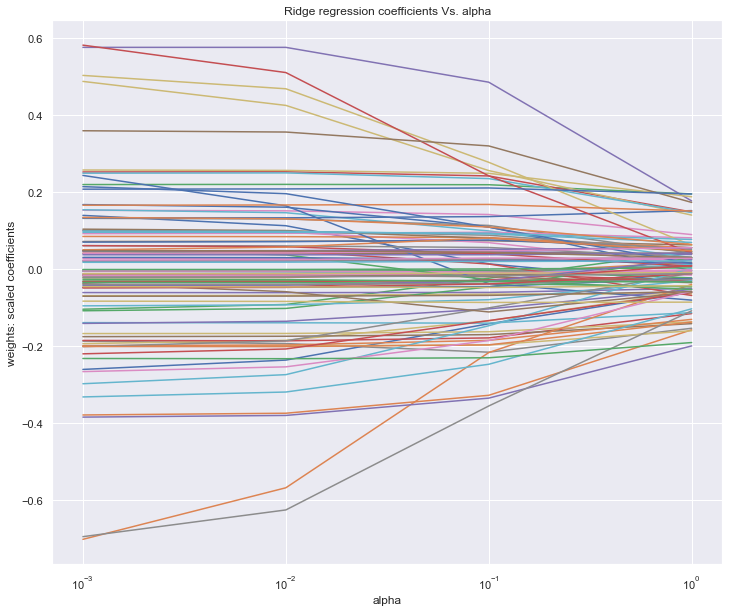

In [17]:
alpha_ridge = np.array([0.001, 0.01, 0.1, 1])
plt.figure(figsize=(12,10))
ax = plt.gca()
ax.plot(alpha_ridge, ridge_coefs[:4])
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights: scaled coefficients')
plt.title('Ridge regression coefficients Vs. alpha')
#plt.legend(df.columns, loc='right') #too messy to visualize legeneds
plt.show()

| Ridge | alpha = 0.001 | alpha = 0.01 | alpha = 0.1 | alpha = 1 |
|---|---|---|---|---|
| MSE on test data | 0.28899084199129454 | 0.28833702763077906 | 0.2861865141543314 | 0.28312347875375937 |
| model complexity | 8.647898629809141 | 8.007966118757498 | 5.618357323383812 | 3.108633329587244 |
| regularized cost | 0.2976387406211037 | 0.36841668881835404 | 0.8480222464927126 | 3.3917568083410035 |

**Which ridge regressor will you choose?**

MSE on test data is smallest when alpha = 1 with the lowest model complexity among all alpha values.
With additional tests with higher alpha values, it seems to be the optimal alpha to have best score is when alpha=1.


**Please select two attributes to visualize the regression models with greyscale contours on the target value,
choose darker color for higher value. Please label the axis with the names of the attributes and specify tick values.**

Chosen model: Lasso Regression

Before visualization, I would like to revisit Lasso Regression model to choose the attributes with highest coefficient.
To select, I used alpha value as 0.001 for Lasso Regression. Based on the coefficient from Lasso Regression, I chose
top two attributes that show biggest absolute value for coefficient. These two attributes will show the stronger
relationship to the crime rate prediction.

In [18]:
alpha = 0.001

lasso = linear_model.Lasso(alpha=alpha)
lasso.fit(x_train, y_train)
#print(list(map(lambda x: round(x, 3), lasso.coef_)))

# find top 2 attributes with highest weightage
# did not implement the part checking if there is only one argument with largest coefficient
# data already only returns two different coefficient as top two coefficients
top_two = sorted(abs(lasso.coef_),reverse=True)[:2]
top_attr_ind = int(np.argwhere(abs(lasso.coef_) == top_two[0])[0])
second_attr_ind = int(np.argwhere(abs(lasso.coef_) == top_two[1])[0])

# get the column label for original data set
top_attr = selected_column[top_attr_ind]
second_attr = selected_column[second_attr_ind]

# get the final data to plot
plot_data = data.loc[:,[top_attr, second_attr]]
plot_data

,49,55
0,0.59,0.14
1,0.47,0.24
2,0.44,0.46
3,0.54,0.33
4,0.91,0.06
...,...,...
1989,0.68,0.11
1990,0.63,0.42
1991,0.42,0.54
1992,0.65,0.17


After selection, we can see that column 49 and 55 are chosen. Based on `communities.name` file's description, these two
attributes are "PctKids2Par", which is percentage of kids in family housing with two parents and "PctIlleg", percentage
of kids born to never married. Intuitively, I am not able to fully understand the strong relationship to crime prediction,
but we will see how this model works by visualization.

In [19]:
lasso_vis = linear_model.Lasso(alpha =0.001)
lasso_vis.fit(plot_data, data.iloc[:,-1].values)
y_pred = lasso_vis.predict(plot_data)

attr1 = plot_data.iloc[:,0].values
attr2 = plot_data.iloc[:,1].values
#xx, yy = np.meshgrid(attr1, attr2)
#mesh_data = np.c_[xx.ravel(), yy.ravel()]
#y_pred1 = lasso_vis.predict(mesh_data).reshape(1994, 1994)

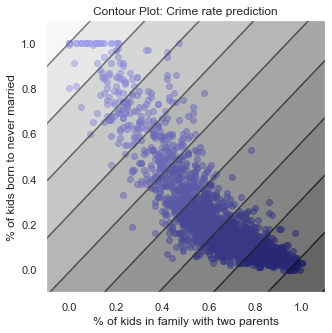

In [20]:
def my_linspace(min_value, max_value, steps):
    diff = max_value - min_value
    return np.linspace(min_value - 0.1 * diff, max_value + 0.1 * diff, steps)
steps = 200

x0 = my_linspace(min(attr1), max(attr1), steps)
x1 = my_linspace(min(attr2), max(attr2), steps)
xx0, xx1 = np.meshgrid(x0, x1)
mesh_data1 = np.c_[xx0.ravel(), xx1.ravel()]
y_pred2 = lasso_vis.predict(mesh_data1).reshape(steps, steps)

plt.figure(figsize= (5,5))
ax = plt.axes()
ax.set_facecolor("white")
plt.title("Contour Plot: Crime rate prediction")
plt.xlabel("% of kids in family with two parents")
plt.ylabel("% of kids born to never married")
plt.scatter(attr1, attr2, c='blue', alpha = 0.5)
plt.contourf(xx0, xx1, y_pred2, levels=10, cmap='gray', alpha = 0.7)
plt.contour(xx0, xx1, y_pred2, levels=10, colors='black', alpha=0.5)
plt.show()


### Question 2

In [21]:
y_train = np.array([0 if i < 0.1 else 1 if i < 0.26 else 2 for i in y_train])
y_test = np.array([0 if i < 0.1 else 1 if i < 0.26 else 2 for i in y_test])

#### 1) Logistic Regression


In [22]:
estimator = linear_model.LogisticRegression(C=10, multi_class='ovr', max_iter=400)
estimator.fit(x_train, y_train)

LogisticRegression(C=10, max_iter=400, multi_class='ovr')

In [23]:
print("The size of test set is: ", x_test.shape[0], "data points.")

The size of test set is:  200 data points.


**The size of test set:** 200 data points - 10% of entire data set


Text(30.5, 0.5, 'Actual')

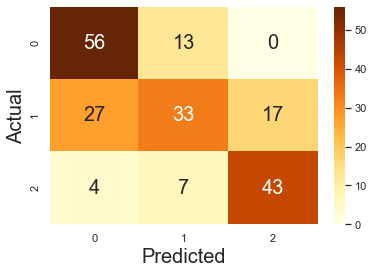

In [24]:
import seaborn as sb

y_logit_pred = estimator.predict(x_test)

#manual check
#sum(y_logit_pred == y_test)

confusion_matrix = metrics.confusion_matrix(y_test, y_logit_pred, labels=[0,1,2])

sb.heatmap(confusion_matrix, annot=True, annot_kws={"size":20}, cmap='YlOrBr')
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)

#display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=estimator.classes_)
#print(confusion_matrix)
#display.plot(cmap='GnBu')

**Confusion Matrix**

| - | *Predicted Class = 1* | *Predicted Class = 2* | *Predicted Class = 3* |
|---|---|---|---|
| *Actual Class = 1* | 56 | 13 | 0 |
| *Actual Class = 2* | 27 | 33 | 17 |
| *Actual Class = 3* | 4 | 7 | 43 |

In [25]:
estimator.score(x_test, y_test)

0.66

**What is the score of the logistic regression model?**
0.66

**What is your guess for the score function?**

I thought about getting F1 score by using precision and recall, which is also aligned with using harmonic mean of
precision and recall value. As precision and recall are in trade-off relationship up to certain point, so the score
should consider how to balance out these two.

#### 2) Visualization

Visualize the change of training error and test error in response to the change of complexity trade-off parameter C.

In [26]:
num_C = 10
C = [1.0] * num_C
for i in range(num_C):
    C[i] = pow(10, i-3)

inv_log_likelihood_train = [0.0] * num_C
inv_log_likelihood_test = [0.0] * num_C

In [27]:
#build your models here

for i in range(len(C)):
    logit = linear_model.LogisticRegression(C=C[i], multi_class='multinomial', solver='newton-cg')
    logit.fit(x_train, y_train)
    # get cross entropy loss (log loss) by each parameter C
    inv_log_likelihood_train[i] = metrics.log_loss(y_train, logit.predict_proba(x_train))
    inv_log_likelihood_test[i] = metrics.log_loss(y_test, logit.predict_proba(x_test))

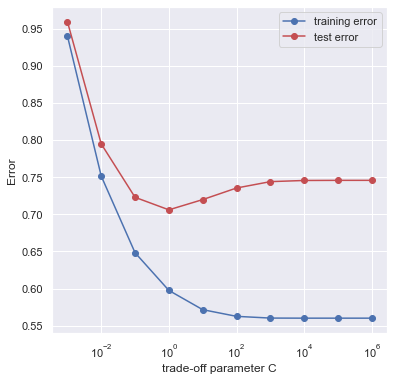

In [28]:
plt.figure(figsize = (6, 6))
plt.xscale('log')
plt.plot(C, inv_log_likelihood_train, 'bo-', C, inv_log_likelihood_test, 'ro-')
plt.legend(['training error','test error'])
plt.xlabel('trade-off parameter C')
plt.ylabel('Error')
plt.show()

From above plot, we can understand that training error goes down as trade-off parameter gets bigger. When the parameter
value is too low (e.g. C =0.001), it is strongly regularized and holds a risk of underfitting the data. As the graph shows,
there is a huge error with low parameters for both test and train data.

Higher value of parameter C means higher complexity and assigning bigger values to the weights for each parameter, so
error will go down for train data. However, it has a risk of overfitting the data. This can be validated with test error.

Test error is lowest when C=1, then it goes up again as C value increases. This could mean that training model was overfitted
with higher C parameter values.